# Prerequisite

When u are not familiar with -> `pip install -r requirements.txt`, use this codeblock for installing the required packages

In [49]:
# !pip install jupyter
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import sklearn.metrics as metrics
import pickle

# Functions for evaluation purposes

In [51]:
def resultClassifierfloat(row):
    threshold = 0.5
    if (row['prediction'] > threshold and row['label'] == True):
        return 'TP'
    if (row['prediction'] < threshold and row['label'] == False):
        return 'TN'
    if (row['prediction'] < threshold and row['label'] == True):
        return 'FN'
    if (row['prediction'] > threshold and row['label'] == False):
        return 'FP'


def resultClassifierint(row):
    if (row['label'] == row['prediction'] and row['label'] == True):
        return 'TP'
    if (row['label'] == row['prediction'] and row['label'] == False):
        return 'TN'
    if (row['label'] != row['prediction'] and row['label'] == True):
        return 'FN'
    if (row['label'] != row['prediction'] and row['label'] == False):
        return 'FP'

# ! CHANGED THIS TO HANDLE 0 FP
def evaluation(model, name, X_test, y_test):
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    print(f"\n--- {name} Results ---")
    print(f"Accuracy:  {accuracy_score(y_test, predictions):.4f}")
    print(f"Precision: {precision_score(y_test, predictions):.4f}")
    print(f"Recall:    {recall_score(y_test, predictions):.4f}")
    print(f"F1 Score:  {f1_score(y_test, predictions):.4f}")
    print(f"AUC Score: {roc_auc_score(y_test, probs):.4f}")
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f"Matrix:    TP={tp}, FP={fp}, TN={tn}, FN={fn}")

# Load preprocessed data set

Split into train, test etc

In [52]:
print("Loading dataset.")
# Load the preprocessed file (which now already contains the '%' column)
final_trainset = pd.read_csv('trainset_reconstructed.csv').fillna(0)

# Filter for high-confidence matches (>88%) to remove noise
# Convert score to numeric (just in case)
final_trainset['%'] = pd.to_numeric(final_trainset['%'], errors='coerce').fillna(0)

# Apply the 0.88 Threshold
# We keep matches > 0.88. We keep ALL non-matches (0).
clean_positives = final_trainset[(final_trainset['match'] == 1) & (final_trainset['%'] >= 0.88)]
clean_negatives = final_trainset[final_trainset['match'] == 0]

# Re-balance negatives to 50/50 (Downsample to match the new, smaller positive count)
if len(clean_positives) > 0:
    clean_negatives = clean_negatives.sample(n=len(clean_positives), random_state=42)
    final_trainset = pd.concat([clean_positives, clean_negatives]).sample(frac=1, random_state=42).fillna(0)
    print(f"Filtered Dataset Size: {len(final_trainset)} rows.")
else:
    print("No matches found above the threshold.")

# Define the target
target = 'match'

# Split the data into 80% train and 20% test (using GroupShuffleSplit to prevent data leak)
splitter = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state=42)
train_inds, test_inds = next(splitter.split(final_trainset, groups=final_trainset['child_id']))

train_set = final_trainset.iloc[train_inds]
test_set = final_trainset.iloc[test_inds]

print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Loading dataset.
Filtered Dataset Size: 113592 rows.
Training set size: 90871
Test set size: 22721


# Traininig Phase (English / Initial Model)

In [53]:
# Legacy features
feature_cols_legacy = ['title_sim_legacy', 'content_sim_legacy', 'date_binary']

X_train_legacy = train_set[feature_cols_legacy]
y_train = train_set[target]

X_test_legacy = test_set[feature_cols_legacy]
y_test = test_set[target]

# Random forest (same settings as before)
rf_legacy = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_legacy.fit(X_train_legacy, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [54]:

filename = 'model_rf_initial.pkl'
pickle.dump(rf_legacy, open(filename, 'wb'))
print(f"Saved: {filename}")


Saved: model_rf_initial.pkl


# Training Phase (Dutch / Fixed Model)

In [55]:
# Dutch features
feature_cols_dutch = ['title_sim_dutch', 'content_sim_dutch', 'date_binary']

X_train_dutch = train_set[feature_cols_dutch]
y_train = train_set[target]

X_test_dutch = test_set[feature_cols_dutch]
y_test = test_set[target]

# Same random forest
rf_dutch = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_dutch.fit(X_train_dutch, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [56]:

filename = 'model_rf_fixed.pkl'
pickle.dump(rf_dutch, open(filename, 'wb'))
print(f"Saved: {filename}")


Saved: model_rf_fixed.pkl


# Evaluation Phase (Both)

In [57]:
evaluation(rf_legacy, "Legacy Model (Jaccard/Stemming)", X_test_legacy, y_test)


--- Legacy Model (Jaccard/Stemming) Results ---
Accuracy:  0.9879
Precision: 0.9960
Recall:    0.9800
F1 Score:  0.9879
AUC Score: 0.9935
Matrix:    TP=11249, FP=45, TN=11197, FN=230


In [58]:
evaluation(rf_dutch, "New Model (Dutch Vectors)", X_test_dutch, y_test)


--- New Model (Dutch Vectors) Results ---
Accuracy:  0.9857
Precision: 0.9946
Recall:    0.9769
F1 Score:  0.9857
AUC Score: 0.9935
Matrix:    TP=11214, FP=61, TN=11181, FN=265


Comparing the models:

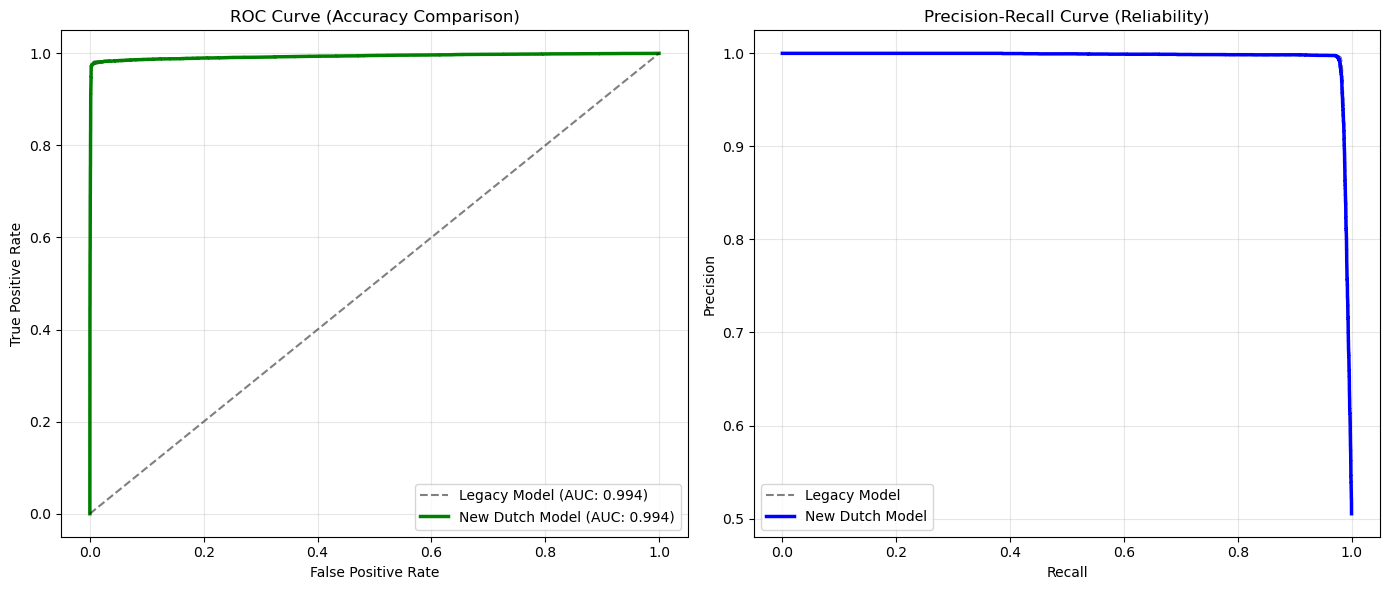

In [59]:
# Get probabilities for the curve
probs_legacy = rf_legacy.predict_proba(X_test_legacy)[:, 1]
probs_dutch = rf_dutch.predict_proba(X_test_dutch)[:, 1]

# Plot ROC Curve
fpr_a, tpr_a, _ = roc_curve(y_test, probs_legacy)
fpr_b, tpr_b, _ = roc_curve(y_test, probs_dutch)

plt.figure(figsize=(14, 6))

# Subplot ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_a, tpr_a, label=f'Legacy Model (AUC: {auc(fpr_a, tpr_a):.3f})', linestyle='--', color='grey')
plt.plot(fpr_b, tpr_b, label=f'New Dutch Model (AUC: {auc(fpr_b, tpr_b):.3f})', color='green', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Accuracy Comparison)')
plt.legend()
plt.grid(alpha=0.3)

# Subplot Precision-0Recall
prec_a, rec_a, _ = precision_recall_curve(y_test, probs_legacy)
prec_b, rec_b, _ = precision_recall_curve(y_test, probs_dutch)

plt.subplot(1, 2, 2)
plt.plot(rec_a, prec_a, label='Legacy Model', linestyle='--', color='grey')
plt.plot(rec_b, prec_b, label='New Dutch Model', color='blue', linewidth=2.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Reliability)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
#plt.savefig('model_comparison.png')
plt.show()

# Error Analysis

In [72]:
# setting pandas to show full text
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)

# loading the big csv files once so we dont have to keep doing it
print("loading raw text files.")
# using just the cols we need
children_df = pd.read_csv('data/full_children.csv', usecols=['id', 'title', 'content'])
parents_df = pd.read_csv('data/full_parents.csv', usecols=['id', 'title', 'content'])

# renaming to make the merge easy
children_df = children_df.rename(columns={'id': 'child_id', 'title': 'child_title', 'content': 'child_content'})
parents_df = parents_df.rename(columns={'id': 'parent_id', 'title': 'parent_title', 'content': 'parent_content'})

loading raw text files.


In [73]:
print("\n--- LEGACY MODEL: CORRECT PREDICTIONS ---")

# loading the legacy model
with open('model_rf_initial.pkl', 'rb') as f:
    model_legacy = pickle.load(f)

# predicting
cols_legacy = ['title_sim_legacy', 'content_sim_legacy', 'date_binary']
preds_legacy = model_legacy.predict(test_set[cols_legacy])
df_legacy = test_set.copy()
df_legacy['pred'] = preds_legacy

# filtering for correct stuff
tp_legacy = df_legacy[(df_legacy['pred'] == 1) & (df_legacy['match'] == 1)] # true positives
tn_legacy = df_legacy[(df_legacy['pred'] == 0) & (df_legacy['match'] == 0)] # true negatives

print(f"True Positives (hits): {len(tp_legacy)}")
print(f"True Negatives (correct rejections): {len(tn_legacy)}")

# displaying content for TP
print("\nTop 5 True Positives (Matches it found):")
tp_text = tp_legacy.merge(children_df, on='child_id', how='left').merge(parents_df, on='parent_id', how='left')
display(tp_text[['child_id', 'parent_id', 'title_sim_legacy', 'child_title', 'parent_title', 'child_content', 'parent_content']].head())

# displaying content for TN
print("\nTop 5 True Negatives (Correctly said NO):")
tn_text = tn_legacy.merge(children_df, on='child_id', how='left').merge(parents_df, on='parent_id', how='left')
display(tn_text[['child_id', 'parent_id', 'title_sim_legacy', 'child_title', 'parent_title', 'child_content', 'parent_content']].head())


--- LEGACY MODEL: CORRECT PREDICTIONS ---
True Positives (hits): 11249
True Negatives (correct rejections): 11197

Top 5 True Positives (Matches it found):


child_id  parent_id  title_sim_legacy  \
0    977618     975976               0.0   
1   1195809    1195769               0.0   
2    979111     979028               0.2   
3    852449     850711               0.0   
4   1290066    1289938               0.0   

                                            child_title  \
0                                             Beursweek   
1             Alleen in Duitsland zet de loongroei door   
2     Huizen werden gemiddeld halve ton duurder in 2021   
3  Aantal moordpogingen Limburg gehalveerd in acht jaar   
4                                      BNR Ochtendspits   

                                                                  parent_title  \
0                                           prijs van energie 86 procent hoger   
1             mild pessimisme zorgt voor historisch laag consumentenvertrouwen   
2  gemiddelde transactieprijs koopwoning in 2021 gestegen tot 387 duizend euro   
3                             1 op 5 jongeren slachtoffer van huiselijk geweld   
4      detailhandel verkocht minder, maar zette meer om in het tweede kwartaal   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          


Top 5 True Negatives (Correctly said NO):


child_id  parent_id  title_sim_legacy  \
0   1257850     979792          0.000000   
1    679292    1047089          0.000000   
2    683257     760010          0.083333   
3   1354160    1005313          0.083333   
4    651838    1271119          0.100000   

                                                                  child_title  \
0                                 Blij over eigen leven, boos op buitenwereld   
1  Minder verkeer op de weg in 2020, maar nog steeds veel doden: hoe kan dat?   
2                                       Eerste Sint Piterferskes over Aldemar   
3                 Toename stikstofoverschot in landbouw door droge zomer 2022   
4                                            procent migrantenachtergrond; 42   

                                                    parent_title  \
0                purperslak verder toegenomen in zeeuwse wateren   
1  klein aantal bedrijven met langdurige problematische schulden   
2            12,8 duizend inwoners erbij in eerste kwartaal 2021   
3                  machine-industrie in nederland blijft groeien   
4              prijzen koopwoningen bijna 6 procent lager in mei   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
print("\n--- LEGACY MODEL: ERRORS ---")

# we already have the predictions from the cell above in 'df_legacy'

# filtering for errors
fp_legacy = df_legacy[(df_legacy['pred'] == 1) & (df_legacy['match'] == 0)] # false pos
fn_legacy = df_legacy[(df_legacy['pred'] == 0) & (df_legacy['match'] == 1)] # false neg (misses)

print(f"False Positives: {len(fp_legacy)}")
print(f"False Negatives: {len(fn_legacy)}")

# displaying FP
print("\nTop 5 False Positives (Hallucinations?):")
if len(fp_legacy) > 0:
    fp_text = fp_legacy.merge(children_df, on='child_id', how='left').merge(parents_df, on='parent_id', how='left')
    display(fp_text[['child_id', 'parent_id', 'title_sim_legacy', 'child_title', 'parent_title', 'child_content', 'parent_content']].head())
else:
    print("none found")

# displaying FN
print("\nTop 5 False Negatives (Missed matches):")
if len(fn_legacy) > 0:
    fn_text = fn_legacy.merge(children_df, on='child_id', how='left').merge(parents_df, on='parent_id', how='left')
    display(fn_text[['child_id', 'parent_id', 'title_sim_legacy', 'child_title', 'parent_title', 'child_content', 'parent_content']].head())
else:
    print("none found")


--- LEGACY MODEL: ERRORS ---
False Positives: 45
False Negatives: 230

Top 5 False Positives (Hallucinations?):


child_id  parent_id  title_sim_legacy  \
0   1238402    1239423          0.083333   
1    997375     996775          0.000000   
2   1454078    1452061          0.000000   
3   1390843    1387193          0.071429   
4   1416929    1018533          0.363636   

                                                                   child_title  \
0                    CO2-uitstoot 9 procent lager in 2022, Urgendadoel gehaald   
1                                                           Haast met btw-stop   
2                                          Nederland heeft 18 miljoen inwoners   
3  684 verkeersdoden in 2023, aantal fietsende verkeersslachtoffers toegenomen   
4                                Omzetgroei horeca zet door in eerste kwartaal   

                                                                parent_title  \
0                                     werkloosheid in februari licht gedaald   
1  bijna derde jongeren in horeca na eerste coronajaar zonder werknemersbaan   
2                      consumptie huishoudens krimpt met 0,7 procent in juni   
3                                  inflatie stijgt naar 3,1 procent in maart   
4             hogere bevolkingsgroei door meer immigratie in eerste kwartaal   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            


Top 5 False Negatives (Missed matches):


child_id  parent_id  title_sim_legacy  \
0    658211     657415          0.000000   
1   1110150     820688          0.083333   
2    983687     793477          0.000000   
3   1461192    1368008          0.000000   
4   1291860     667719          0.176471   

                                                                                                                                child_title  \
0                                                                                             Hoog bedrag aan overwaarde voor huiseigenaren   
1                                                                                           42 procent van alle woningen is een rijtjeshuis   
2                                                               Gemeente vindt AV veilig, hoewel 70% van bevolking ontevreden is over BOA’s   
3                                                                         Bijna 60 procent Nederlanders heeft last van hondenpoep op straat   
4  Cijfers CBS over instroom en uitstroom aantal werknemers in zorg en welzijn. Uitstroom groeit harder dan instroom - Stichting Beroepseer   

                                       parent_title  \
0  Koopwoningen bijna 9 procent duurder in november   
1                   8 miljoen woningen in nederland   
2                            odin 2020 noordvleugel   
3                           veiligheidsmonitor 2023   
4                      arbeidsmarkt zorg en welzijn   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [75]:
print("\n--- DUTCH MODEL: CORRECT PREDICTIONS ---")

# loading the new dutch model
with open('model_rf_fixed.pkl', 'rb') as f:
    model_dutch = pickle.load(f)

# predicting
cols_dutch = ['title_sim_dutch', 'content_sim_dutch', 'date_binary']
preds_dutch = model_dutch.predict(test_set[cols_dutch])
df_dutch = test_set.copy()
df_dutch['pred'] = preds_dutch

# filtering correct ones
tp_dutch = df_dutch[(df_dutch['pred'] == 1) & (df_dutch['match'] == 1)]
tn_dutch = df_dutch[(df_dutch['pred'] == 0) & (df_dutch['match'] == 0)]

print(f"True Positives (hits): {len(tp_dutch)}")
print(f"True Negatives (correct rejections): {len(tn_dutch)}")

# showing TP
print("\nTop 5 True Positives (Matches it found):")
tp_dutch_text = tp_dutch.merge(children_df, on='child_id', how='left').merge(parents_df, on='parent_id', how='left')
display(tp_dutch_text[['child_id', 'parent_id', 'title_sim_dutch', 'child_title', 'parent_title', 'child_content', 'parent_content']].head())

# showing TN
print("\nTop 5 True Negatives (Correctly said NO):")
tn_dutch_text = tn_dutch.merge(children_df, on='child_id', how='left').merge(parents_df, on='parent_id', how='left')
display(tn_dutch_text[['child_id', 'parent_id', 'title_sim_dutch', 'child_title', 'parent_title', 'child_content', 'parent_content']].head())


--- DUTCH MODEL: CORRECT PREDICTIONS ---
True Positives (hits): 11214
True Negatives (correct rejections): 11181

Top 5 True Positives (Matches it found):


child_id  parent_id  title_sim_dutch  \
0    977618     975976         0.177513   
1   1195809    1195769         0.492900   
2    979111     979028         0.762316   
3    852449     850711         0.313880   
4   1290066    1289938         0.000000   

                                            child_title  \
0                                             Beursweek   
1             Alleen in Duitsland zet de loongroei door   
2     Huizen werden gemiddeld halve ton duurder in 2021   
3  Aantal moordpogingen Limburg gehalveerd in acht jaar   
4                                      BNR Ochtendspits   

                                                                  parent_title  \
0                                           prijs van energie 86 procent hoger   
1             mild pessimisme zorgt voor historisch laag consumentenvertrouwen   
2  gemiddelde transactieprijs koopwoning in 2021 gestegen tot 387 duizend euro   
3                             1 op 5 jongeren slachtoffer van huiselijk geweld   
4      detailhandel verkocht minder, maar zette meer om in het tweede kwartaal   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


Top 5 True Negatives (Correctly said NO):


child_id  parent_id  title_sim_dutch  \
0   1257850     979792         0.281029   
1    679292    1047089         0.431280   
2    683257     760010         0.071869   
3   1354160    1005313         0.568497   
4    651838    1271119         0.509581   

                                                                  child_title  \
0                                 Blij over eigen leven, boos op buitenwereld   
1  Minder verkeer op de weg in 2020, maar nog steeds veel doden: hoe kan dat?   
2                                       Eerste Sint Piterferskes over Aldemar   
3                 Toename stikstofoverschot in landbouw door droge zomer 2022   
4                                            procent migrantenachtergrond; 42   

                                                    parent_title  \
0                purperslak verder toegenomen in zeeuwse wateren   
1  klein aantal bedrijven met langdurige problematische schulden   
2            12,8 duizend inwoners erbij in eerste kwartaal 2021   
3                  machine-industrie in nederland blijft groeien   
4              prijzen koopwoningen bijna 6 procent lager in mei   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [76]:
print("\n--- DUTCH MODEL: ERRORS ---")

# using predictions from previous cell

# filtering errors
fp_dutch = df_dutch[(df_dutch['pred'] == 1) & (df_dutch['match'] == 0)]
fn_dutch = df_dutch[(df_dutch['pred'] == 0) & (df_dutch['match'] == 1)]

print(f"False Positives: {len(fp_dutch)}")
print(f"False Negatives: {len(fn_dutch)}")

# showing FP
print("\nTop 5 False Positives (Checking for hidden matches):")
if len(fp_dutch) > 0:
    fp_dutch_text = fp_dutch.merge(children_df, on='child_id', how='left').merge(parents_df, on='parent_id', how='left')
    display(fp_dutch_text[['child_id', 'parent_id', 'title_sim_dutch', 'child_title', 'parent_title', 'child_content', 'parent_content']].head())
else:
    print("none found")

# showing FN
print("\nTop 5 False Negatives (Missed matches):")
if len(fn_dutch) > 0:
    fn_dutch_text = fn_dutch.merge(children_df, on='child_id', how='left').merge(parents_df, on='parent_id', how='left')
    display(fn_dutch_text[['child_id', 'parent_id', 'title_sim_dutch', 'child_title', 'parent_title', 'child_content', 'parent_content']].head())
else:
    print("none found")


--- DUTCH MODEL: ERRORS ---
False Positives: 61
False Negatives: 265

Top 5 False Positives (Checking for hidden matches):


child_id  parent_id  title_sim_dutch  \
0   1238402    1239423         0.461932   
1   1208491     916785         0.719560   
2    997375     996775         0.185483   
3   1454078    1452061         0.555359   
4   1390843    1387193         0.445438   

                                                                   child_title  \
0                    CO2-uitstoot 9 procent lager in 2022, Urgendadoel gehaald   
1                                Inflatie naar 9,9 procent gedaald in november   
2                                                           Haast met btw-stop   
3                                          Nederland heeft 18 miljoen inwoners   
4  684 verkeersdoden in 2023, aantal fietsende verkeersslachtoffers toegenomen   

                                                                parent_title  \
0                                     werkloosheid in februari licht gedaald   
1                 productie industrie groeit met bijna 10 procent in oktober   
2  bijna derde jongeren in horeca na eerste coronajaar zonder werknemersbaan   
3                      consumptie huishoudens krimpt met 0,7 procent in juni   
4                                  inflatie stijgt naar 3,1 procent in maart   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  


Top 5 False Negatives (Missed matches):


child_id  parent_id  title_sim_dutch  \
0    658211     657415         0.389790   
1    983687     793477         0.274535   
2    657887     657415         0.352585   
3   1461192    1368008         0.288510   
4   1291860     667719         0.724439   

                                                                                                                                child_title  \
0                                                                                             Hoog bedrag aan overwaarde voor huiseigenaren   
1                                                               Gemeente vindt AV veilig, hoewel 70% van bevolking ontevreden is over BOA’s   
2                                                                                          Nederlandse huizenprijzen opnieuw flink gestegen   
3                                                                         Bijna 60 procent Nederlanders heeft last van hondenpoep op straat   
4  Cijfers CBS over instroom en uitstroom aantal werknemers in zorg en welzijn. Uitstroom groeit harder dan instroom - Stichting Beroepseer   

                                       parent_title  \
0  Koopwoningen bijna 9 procent duurder in november   
1                            odin 2020 noordvleugel   
2  Koopwoningen bijna 9 procent duurder in november   
3                           veiligheidsmonitor 2023   
4                      arbeidsmarkt zorg en welzijn   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Looking at the actual articles where the models messed up (False Positives and False Negatives) to see what's actually going on:

### 1. The Legacy Model is kind of "blind"
The model misses obvious matches because it's too focused on exact words:
* Example (False Negative): child_id 0 vs parent_id 658211
* Child Article: "High surplus value for homeowners" (Hoog bedrag aan overwaarde)
* Parent Article: "Homes almost 9% more expensive" (Koopwoningen bijna 9 procent duurder)

Both articles are clearly about the housing market and rising prices. But because the titles didn't share exact keywords (one said "surplus" other "expensive"), the legacy model gave it a score of 0 - it was completely blind to the connection. This confirms that old Jaccard approach has ehh Recall and ignores stuff that isn't basically a copy-paste.

### 2. The New Model: Hallucinations vs. Hidden Gems
The new Dutch Vector model fixes the blindness, but it introduces a new kinds of issues lol.

Bad part: it gets confused by numbers (Hallucinations)
Because every CBS article is written in the same "bureaucratic style," the model sometimes thinks different stats are the same thing.
* Example (False Positive): child_id 1120849 vs parent_id 916785
* Child: "Inflation fell to 9.9 percent"
* Parent: "Industrial production grows by nearly 10 percent"

My model gave this a high score (0.72). It probably say "9.9" or "10" percents, and words like "Growth/Decline" and got too excited to make the match. It struggles to tell the difference between types of economic stats when the sentence structure is identical.

Good part: it found matches the og trainset (whatever code was used to do the matching) missed (Hidden Gems in a sense). So, in a sense, the model is smart.
* Example (False Positive): child_id 4129186 vs parent_id 667719
* Child: "CBS figures on inflow/outflow employees in care..."
* Parent: "Labor market care and welfare"

The dataset labeled this as a "Non-Match" (0), but my model gave it a 0.72. Reading the text, both explicitly discuss the "1.4 million employees" in the care sector. The model was right, the label was wrong.

### Comparsion / Conclusion
On that Housing example where the Legacy model scored 0, the Dutch model gave it a 0.39. It didn't quite hit the match threshold, but at least it saw something. It wasn't blind.

* Legacy Model: "Safe but blind" (high precision, but misses anything with synonyms).
* New Dutch Model: "Smart but easily confused" (finds the hidden meanings and corrects human labeling errors, but struggles to differentiate between different statistics because the writing style is so similar).

Recommendation: We need to keep the threshold high (like the >0.88 rule) to filter out the "Statistical Hallucinations," while still catching the "Hidden Gems" that the old system missed.

# Feature analysis

Feature Importance - Legacy Model:
              feature  importance
2         date_binary    0.737280
1  content_sim_legacy    0.188679
0    title_sim_legacy    0.074041


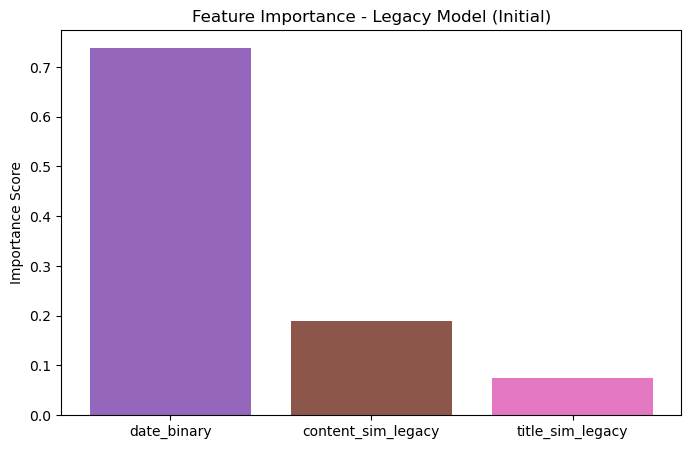

In [78]:
# loading the original model again
with open('model_rf_initial.pkl', 'rb') as f:
    model_legacy = pickle.load(f)

# these are the features we trained on
features_legacy = ['title_sim_legacy', 'content_sim_legacy', 'date_binary']

# getting the importance scores
importances_legacy = model_legacy.feature_importances_

# making a dataframe so its easy to read
feature_df_legacy = pd.DataFrame({
    'feature': features_legacy,
    'importance': importances_legacy
}).sort_values(by='importance', ascending=False)

print("Feature Importance - Legacy Model:")
print(feature_df_legacy)

# plot
plt.figure(figsize=(8, 5))
plt.bar(feature_df_legacy['feature'], feature_df_legacy['importance'], color=['#9467bd', '#8c564b', '#e377c2'])
plt.title("Feature Importance - Legacy Model (Initial)")
plt.ylabel("Importance Score")
plt.show()

Feature Importance (What the model actually cares about):
             feature  importance
2        date_binary    0.790375
1  content_sim_dutch    0.147201
0    title_sim_dutch    0.062424


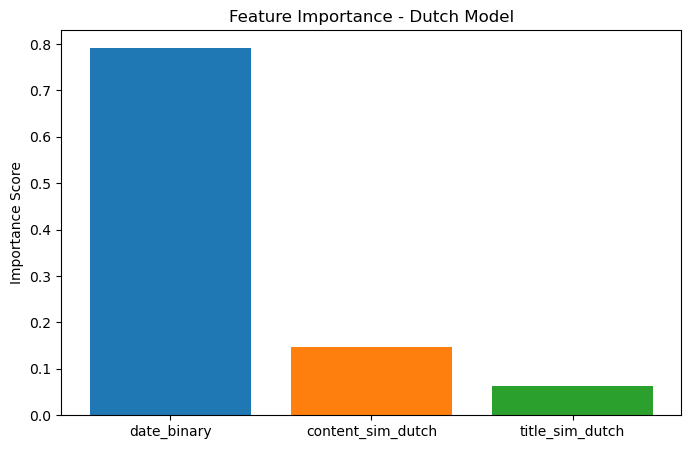

In [79]:
# loading the dutch model again
with open('model_rf_fixed.pkl', 'rb') as f:
    model_dutch = pickle.load(f)

# these are the features we trained on
features = ['title_sim_dutch', 'content_sim_dutch', 'date_binary']

# getting the importance scores
importances = model_dutch.feature_importances_

# making a dataframe so its easy to read
feature_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Feature Importance (What the model actually cares about):")
print(feature_df)

# plot
plt.figure(figsize=(8, 5))
plt.bar(feature_df['feature'], feature_df['importance'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Feature Importance - Dutch Model")
plt.ylabel("Importance Score")
plt.show()

Both are kinda lazy.

### both models are obsessed with dates
`date_binary` is by far the most important feature for both systems.
* legacy model: ~74% importance on date
* dutch model: ~79% importance on date

Basically, both models learned a *shortcut* - metadata, "if these articles were published on the same day, they are probably a match." if the dates don't match, they almost definitely say no.

### hallucinations explained (the traffic vs inflation error)
since both models rely so much on the date, the difference comes down to how they handle the text.
* legacy model: if the date matches, it checks for exact words. if it finds none (score 0), it rejects the match - plays it **saf4e**
* Dutch Model: if the date matches, it checks for context/vibe (vectors). As menitoned, CBS articles use similar jargon ("percent", "increase", "statistics"), so vector score is rarely zero, it’s usually like 0.3 or 0.4.

So, the dutch model sees a date match + a "meh" text score (0.4), so it gets over-confident and marks it as a match. This explains why it matched the traffic deaths with inflation stats—they happened in the same week and sounded bureaucratic.

### POTENTIAL FIX: raise the threshold
So, at the default threshold (0.5), the model is too excited and makes those "traffic vs inflation" errors. But what if we raise the threshold? To 0.8 for example - we could filter out the lazy date-matches (which usually score around 0.4-0.6) and only keep the strong semantic matches (like the housing market example).

# THRESHOLD EXPERIMENTS

In [81]:
# --- COMPARING LEGACY VS STRICT DUTCH ---
print("\n--- 1. LEGACY MODEL PERFORMANCE (BASELINE) ---")

# getting legacy predictions (standard threshold 0.5)
probs_legacy = model_legacy.predict_proba(test_set[cols_legacy])[:, 1]
legacy_preds = (probs_legacy >= 0.5).astype(int)

# saving to df to check errors
df_legacy_check = test_set.copy()
df_legacy_check['pred'] = legacy_preds

fp_leg = df_legacy_check[(df_legacy_check['pred'] == 1) & (df_legacy_check['match'] == 0)]
fn_leg = df_legacy_check[(df_legacy_check['pred'] == 0) & (df_legacy_check['match'] == 1)]
tp_leg = df_legacy_check[(df_legacy_check['pred'] == 1) & (df_legacy_check['match'] == 1)]

print(f"False positives (hallucinations): {len(fp_leg)}")
print(f"False negatives (misses): {len(fn_leg)}")
print(f"True positives (hits): {len(tp_leg)}")


print("\n--- 2. DUTCH MODEL WITH STRICT THRESHOLD (0.8) ---")

# getting the probabilities from the dutch model
# we only care about the probability of it being a match (column 1)
probs_dutch = model_dutch.predict_proba(test_set[cols_dutch])[:, 1]

# applying the new rule: only say 'yes' if the score is higher than 0.8
# this kills the lazy date-matches because they usually score around 0.4-0.7
strict_preds = (probs_dutch >= 0.8).astype(int)

# saving results to a new dataframe
df_strict = test_set.copy()
df_strict['pred'] = strict_preds

# recalculating errors
fp_strict = df_strict[(df_strict['pred'] == 1) & (df_strict['match'] == 0)]
fn_strict = df_strict[(df_strict['pred'] == 0) & (df_strict['match'] == 1)]
tp_strict = df_strict[(df_strict['pred'] == 1) & (df_strict['match'] == 1)]

print(f"False positives (hallucinations): {len(fp_strict)} (dropped from 61)")
print(f"False negatives (misses): {len(fn_strict)}") 
print(f"True positives (hits): {len(tp_strict)}")

# verifying if the specific 'inflation vs production' error is gone
# we know these IDs from the 'Top 5 False Positives' table we generated earlier
target_child = 1208491 # "Inflation fell..."
target_parent = 916785 # "Production grows..."

# checking what the model predicts for this specific pair now
check_error = df_strict[(df_strict['child_id'] == target_child) & (df_strict['parent_id'] == target_parent)]

if not check_error.empty:
    is_match = check_error.iloc[0]['pred']
    # if prediction is 0, it means the model said "NO MATCH"
    print(f"\nDid we fix the inflation error (IDs {target_child} & {target_parent})?")
    print(f"Prediction is now: {is_match} ({'FIXED: Model says NO' if is_match == 0 else 'FAIL: Model says YES'})")


--- 1. LEGACY MODEL PERFORMANCE (BASELINE) ---
False positives (hallucinations): 45
False negatives (misses): 230
True positives (hits): 11249

--- 2. DUTCH MODEL WITH STRICT THRESHOLD (0.8) ---
False positives (hallucinations): 30 (dropped from 61)
False negatives (misses): 315
True positives (hits): 11164

Did we fix the inflation error (IDs 1208491 & 916785)?
Prediction is now: 0.0 (FIXED: Model says NO)


A stricter threshold:

1. Kills the lazy errors

The fix worked exactly like it was supposed to - the specific error where it confused inflation with industrial production is completely gone now. Total hallucinations dropped by more than half, going from 61 down to 30. This basically proves that a lot of those errors were indeed just "lazy date matches" where the model wasn't totally sure (score was probably 0.6 or 0.7) but guessed yes anyway. By raising the bar to 0.8, we forced it to stop guessing on those low-confidence pairs.

2. Trade-off

To get rid of the noise, we had to sacrifice some real matches. Our false negatives went up from 265 to 315, which means we lost about 50 real matches. These were likely weak matches where the articles were technically related but didn't have strong vector overlap, so the model wasn't confident enough to pass the new 0.8 bar.

3. The verdict

Honestly this is good enough, better to be safe than sorry in this case. In a system like this, showing the user wrong info destroys trust immediately. It is way worse to tell a user that "traffic deaths" are the same thing as "inflation" than it is to miss a few marginal matches. The model is no longer too excited - its strict! Potential fix could be manually reviewing the grey area "meh" matches.

**Future fix:** If we really want those 50 matches back, we could retrain the model on "hard negatives" (articles with the same date but different topics) so it learns to trust the text more than the calendar.